In [1]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from itertools import product
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset, random_split
from utils import plot_validation_accuracy

from sklearn.svm import SVC

# SmallCNN

A SGD classifer is not enough to get reliable insights on CIFAR-10 dataset so we will use a lightweight CNN. This will allow us to accurately estimate the influence of training order

In [2]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128), nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# CIFAR-10 Dataset (Vanilla Case)

## Data Loading

As Cifar-10 consist of RGB images, we can define 3 channels of size 32x32.

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),   # CIFAR-10 mean
                         (0.2023, 0.1994, 0.2010))   # CIFAR-10 std
])

cifar_train_dataset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
cifar_test_dataset  = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

X_all = torch.stack([cifar_train_dataset[i][0] for i in range(len(cifar_train_dataset))])
y_all = torch.tensor([cifar_train_dataset[i][1] for i in range(len(cifar_train_dataset))])

val_split = 0.1
n_total = len(X_all)
n_val = int(n_total * val_split)
n_train = n_total - n_val

train_data, val_data = random_split(list(zip(X_all, y_all)), [n_train, n_val])

X_train, y_train = zip(*train_data)
X_val, y_val     = zip(*val_data)

X_train = torch.stack(X_train)
y_train = torch.tensor(y_train)
X_val   = torch.stack(X_val)
y_val   = torch.tensor(y_val)

X_test = torch.stack([cifar_test_dataset[i][0] for i in range(len(cifar_test_dataset))])
y_test = torch.tensor([cifar_test_dataset[i][1] for i in range(len(cifar_test_dataset))])

train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val, y_val)
test_dataset  = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Train: 45000, Val: 5000, Test: 10000


## Analysis

We will investigate convergence time using a threshold epsilon (ε) based on validation loss. We found in litterature, ε = 1e-2 (0.01) is often used as a practical threshold in early stopping. This means if validation loss improves by less than 1% between epochs, we consider the model has plateaued.

In [6]:
epsilon = 1e-2

### (0) Base Case

Let's try as the Vanilla Base Case: Train on the entire dataset using uniform random shuffling for each epoch.

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 15
stage_accs = []
val_loss = 0
convergence_idx = -1

for epoch in range(n_epochs):
    # TRAINING
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(train_loader.dataset)

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if epoch > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = epoch
            val_loss = val_loss_total / val_total
            val_accuracy = val_correct / val_total
            print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {avg_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")
            print(f"------------ The model has converged at epoch {epoch} ------------")
            stage_accs.append(val_accuracy)
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{n_epochs} - Train Loss: {avg_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")
    stage_accs.append(val_accuracy)

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = outputs.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total:.4f}")

Using device: cuda
Epoch 1/15 - Train Loss: 1.3378 - Val Accuracy: 0.6284
Epoch 2/15 - Train Loss: 0.9737 - Val Accuracy: 0.6328
Epoch 3/15 - Train Loss: 0.8277 - Val Accuracy: 0.6924
Epoch 4/15 - Train Loss: 0.7147 - Val Accuracy: 0.7036
Epoch 5/15 - Train Loss: 0.6174 - Val Accuracy: 0.7122
Epoch 6/15 - Train Loss: 0.5248 - Val Accuracy: 0.7118
Epoch 7/15 - Train Loss: 0.4395 - Val Accuracy: 0.7106
Epoch 8/15 - Train Loss: 0.3649 - Val Accuracy: 0.7116
Epoch 9/15 - Train Loss: 0.2952 - Val Accuracy: 0.7060
Epoch 10/15 - Train Loss: 0.2370 - Val Accuracy: 0.7026
Epoch 11/15 - Train Loss: 0.1927 - Val Accuracy: 0.6988
Epoch 12/15 - Train Loss: 0.1607 - Val Accuracy: 0.6942
Epoch 13/15 - Train Loss: 0.1358 - Val Accuracy: 0.6954
Epoch 14/15 - Train Loss: 0.1092 - Val Accuracy: 0.7006
Epoch 15/15 - Train Loss: 0.1077 - Val Accuracy: 0.6886
Test Accuracy: 0.6918


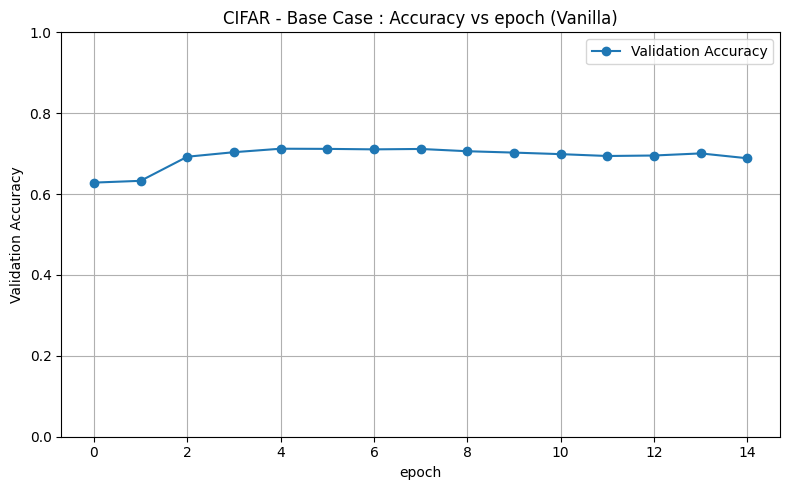

In [38]:
plot_validation_accuracy(
    range(n_epochs),
    stage_accs,
    x_label="epoch",
    title="CIFAR - Base Case : Accuracy vs epoch (Vanilla)",
    convergence_epoch=convergence_idx)

### (1) Curriculum Learning

As curriculum learning is based on giving samples in increasing difficulty level to the model, we first need to define a difficulty function. We will base ours on difference between the distance of each point to the line that goes through all the data points.

#### Pre-analysis

In [6]:
def compute_cifar_difficulty(dataset):
    data_loader = DataLoader(dataset, batch_size=len(dataset))
    images, labels = next(iter(data_loader))
    images = images.view(images.size(0), -1)  # Flatten images

    centroids = [images[labels == i].mean(dim=0) for i in range(10)]
    difficulty = torch.tensor([
        torch.norm(img - centroids[label]).item()
        for img, label in zip(images, labels)
    ])
    return difficulty

#### Analysis

In [13]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

difficulty = compute_cifar_difficulty(train_dataset)
difficulty = (difficulty - difficulty.min()) / (difficulty.max() - difficulty.min())
sorted_indices = np.argsort(difficulty)  # easiest to hardest

batch_size = 64
epochs_per_stage = 10
num_stages = 5

phases = np.linspace(0.1, 1.0, num_stages)
previous_n = 0

stage_accs = []
val_loss = 0
convergence_idx = -1
prev_val_loss = float('inf')


for stage, phase in enumerate(phases):
    # TRAINING
    current_n = int(phase * len(sorted_indices))
    selected_idx = sorted_indices[previous_n:current_n]
    previous_n = current_n

    print(f"\nStage {stage+1}/{num_stages}: Using {len(selected_idx)} new examples")

    X_stage = X_train[selected_idx]
    y_stage = y_train[selected_idx]

    train_dataset_stage = TensorDataset(X_stage, y_stage)
    train_loader_stage = DataLoader(train_dataset_stage, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        # TRAINING
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader_stage:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset_stage)

        # VALIDATION
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                val_loss_total += loss.item() * images.size(0)

                predicted = outputs.argmax(dim=1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss_total / val_total
        val_accuracy = val_correct / val_total

        print(f"Epoch {epoch+1}/{epochs_per_stage} - Train Loss: {total_loss/len(train_dataset_stage):.4f} - Val Accuracy: {val_accuracy:.4f}")

    if stage > 0:
            if np.abs(val_loss - prev_val_loss) < epsilon:
                convergence_idx = phase
                print(f"------------ The model has converged at stage {stage} ------------")
    prev_val_loss = val_loss
    stage_accs.append(val_accuracy)


model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 1/5: Using 4500 new examples
Epoch 1/10 - Train Loss: 1.3712 - Val Accuracy: 0.2900
Epoch 2/10 - Train Loss: 1.0456 - Val Accuracy: 0.3546
Epoch 3/10 - Train Loss: 0.9175 - Val Accuracy: 0.3730
Epoch 4/10 - Train Loss: 0.7809 - Val Accuracy: 0.3854
Epoch 5/10 - Train Loss: 0.6891 - Val Accuracy: 0.4060
Epoch 6/10 - Train Loss: 0.5806 - Val Accuracy: 0.4232
Epoch 7/10 - Train Loss: 0.4847 - Val Accuracy: 0.4200
Epoch 8/10 - Train Loss: 0.3877 - Val Accuracy: 0.4264
Epoch 9/10 - Train Loss: 0.2935 - Val Accuracy: 0.4222
Epoch 10/10 - Train Loss: 0.2208 - Val Accuracy: 0.4232

Stage 2/5: Using 10125 new examples
Epoch 1/10 - Train Loss: 1.1355 - Val Accuracy: 0.5224
Epoch 2/10 - Train Loss: 0.8159 - Val Accuracy: 0.5482
Epoch 3/10 - Train Loss: 0.6597 - Val Accuracy: 0.5676
Epoch 4/10 - Train Loss: 0.4998 - Val Accuracy: 0.5526
Epoch 5/10 - Train Loss: 0.3701 - Val Accuracy: 0.5584
Epoch 6/10 - Train Loss: 0.2589 - Val Accuracy: 0.5642
Epoch 7/10 - Train Loss: 0.1524 - Val Accuracy

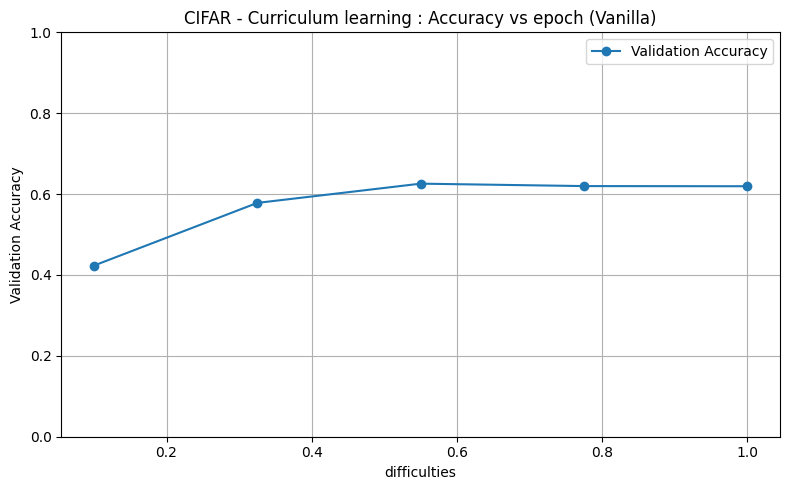

In [14]:
plot_validation_accuracy(
    phases,
    stage_accs,
    x_label="difficulties",
    title="CIFAR - Curriculum learning : Accuracy vs epoch (Vanilla)",
    convergence_epoch=convergence_idx)

### (2) Self-Paced Learning

In Self-Paced Learning, the model is supposed to:

• learn from easier samples first (based on current loss)

• adaptively expand its training set to include harder samples as it becomes more confident

We will use the same X_train, X_test, y_train and y_test computed in the curriculum learning phase.
To implement the SPL we will introduce a difficulty threshold to let the model choose how many samples of this difficulty it is ready to handle.

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 6
samples_per_epoch = len(X_train) // num_epochs

seen_mask = torch.zeros(len(X_train), dtype=torch.bool)

stage_accs = []
val_loss = 0
convergence_idx = -1

for epoch in range(num_epochs):
    model.eval()
    with torch.no_grad():
        unseen_indices = (~seen_mask).nonzero(as_tuple=True)[0]
        unseen_loader = DataLoader(TensorDataset(X_train[unseen_indices], y_train[unseen_indices]),
                                   batch_size=batch_size, shuffle=False)
        if len(unseen_indices)==0:
          break

        all_losses = []
        for images, labels in unseen_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            losses = criterion(outputs, labels)
            all_losses.append(losses.cpu())

        all_losses = torch.cat(all_losses)

    k = min(samples_per_epoch, len(unseen_indices))
    selected_in_unseen = torch.topk(-all_losses, k).indices
    selected_indices = unseen_indices[selected_in_unseen]

    seen_mask[selected_indices] = True

    print(f"Epoch {epoch+1}/{num_epochs}: selected {len(selected_indices)} new samples (total seen: {seen_mask.sum().item()}/{len(X_train)})")

    train_loader_stage = DataLoader(TensorDataset(X_train[selected_indices], y_train[selected_indices]),
                              batch_size=batch_size, shuffle=True)

    model.train()
    total_loss, total_correct = 0, 0
    for images, labels in train_loader_stage:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(labels)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(train_loader_stage.dataset)

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels).mean()
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if epoch > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = epoch
            val_loss = val_loss_total / val_total
            val_accuracy = val_correct / val_total
            print(f"    Train Loss: {total_loss/len(train_loader_stage.dataset):.4f} - Val Accuracy: {val_accuracy:.4f}")
            print(f"------------ The model has converged at epoch {epoch} ------------")
            stage_accs.append(val_accuracy)
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total

    print(f"    Train Loss: {total_loss/len(train_loader_stage.dataset):.4f} - Val Accuracy: {val_accuracy:.4f}")
    stage_accs.append(val_accuracy)

print("Training complete.")

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

Epoch 1: selected 7500 new samples (total seen: 7500/45000)
    Epoch 1/6 - Train Loss: 0.8326 - Val Accuracy: 0.2546
Epoch 2: selected 7500 new samples (total seen: 15000/45000)
    Epoch 2/6 - Train Loss: 0.3252 - Val Accuracy: 0.2804
Epoch 3: selected 7500 new samples (total seen: 22500/45000)
    Epoch 3/6 - Train Loss: 0.6719 - Val Accuracy: 0.3216
Epoch 4: selected 7500 new samples (total seen: 30000/45000)
    Epoch 4/6 - Train Loss: 1.2037 - Val Accuracy: 0.2392
Epoch 5: selected 7500 new samples (total seen: 37500/45000)
    Epoch 5/6 - Train Loss: 0.4598 - Val Accuracy: 0.2564
Epoch 6: selected 7500 new samples (total seen: 45000/45000)
    Epoch 6/6 - Train Loss: 0.7257 - Val Accuracy: 0.2424
Training complete.

Final Test Accuracy: 0.2365


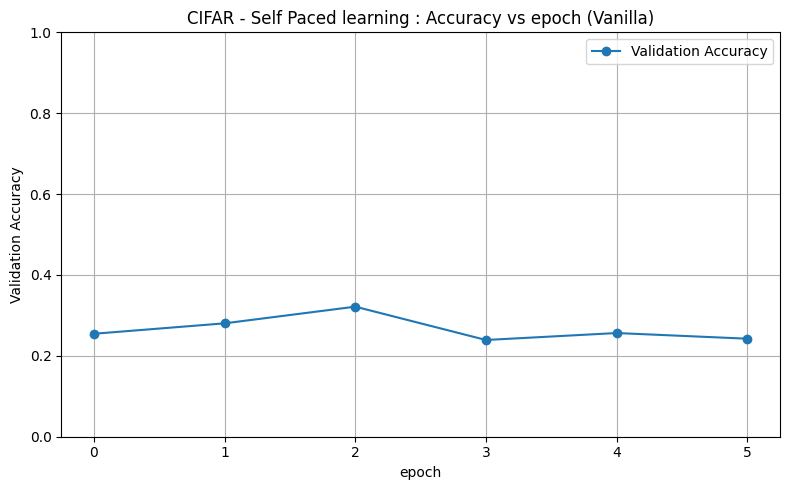

In [25]:
plot_validation_accuracy(
    range(num_epochs),
    stage_accs,
    x_label="epoch",
    title="CIFAR - Self-Paced learning : Accuracy vs epoch (Vanilla)",
    convergence_epoch=convergence_idx)

### (3) Hard-Example Mining

Hard-Example Mining consists in feeding the model only hard examples. In our case, we will consider that a sample is difficult if its normalized difficulty is greater or equal than 0,60 (in other words the top 40%).

In [ ]:
difficulty = compute_cifar_difficulty(train_dataset)
difficulty = (difficulty - difficulty.min()) / (difficulty.max() - difficulty.min())

hard_mask = difficulty >= 0.60
hard_indices = np.where(hard_mask)[0] # we do not shuffle the indices to train on increasingly difficult samples (adapted CL idea)
print(f"Selected {len(hard_indices)} hard examples out of {len(difficulty)} total")

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs = 10

stage_accs = []
val_loss = 0
convergence_idx = -1

X_hard = X_train[hard_indices]
y_hard = y_train[hard_indices]

train_dataset_hard = TensorDataset(X_hard, y_hard)
train_loader_hard = DataLoader(train_dataset_hard, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in train_loader_hard:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(train_dataset_hard)

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if epoch > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = epoch
            val_loss = val_loss_total / val_total
            val_accuracy = val_correct / val_total
            stage_accs.append(val_accuracy)
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(train_dataset_hard):.4f} - Val Accuracy: {val_accuracy:.4f}")
            print(f"------------ The model has converged at epoch {epoch} ------------")
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(train_dataset_hard):.4f} - Val Accuracy: {val_accuracy:.4f}")
    stage_accs.append(val_accuracy)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

Selected 2666 hard examples out of 45000 total
Epoch 1/10 - Train Loss: 2.0560 - Val Accuracy: 0.2116
Epoch 2/10 - Train Loss: 1.5948 - Val Accuracy: 0.2380
Epoch 3/10 - Train Loss: 1.2933 - Val Accuracy: 0.2866
Epoch 4/10 - Train Loss: 1.1129 - Val Accuracy: 0.2760
Epoch 5/10 - Train Loss: 0.9204 - Val Accuracy: 0.2942
Epoch 6/10 - Train Loss: 0.7787 - Val Accuracy: 0.3164
Epoch 7/10 - Train Loss: 0.6111 - Val Accuracy: 0.3238
Epoch 8/10 - Train Loss: 0.4723 - Val Accuracy: 0.3108
Epoch 9/10 - Train Loss: 0.3384 - Val Accuracy: 0.3240
Epoch 10/10 - Train Loss: 0.2676 - Val Accuracy: 0.3112

Final Test Accuracy: 0.2965


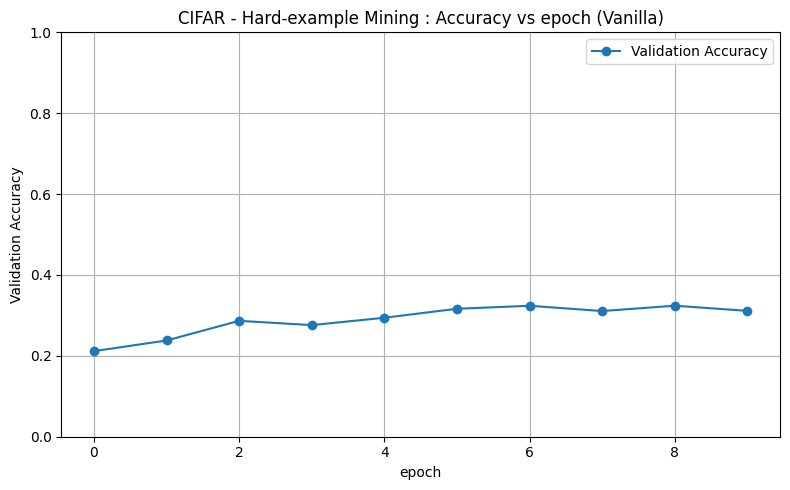

In [8]:
plot_validation_accuracy(
    range(epochs),
    stage_accs,
    x_label="epoch",
    title="CIFAR - Hard-example Mining : Accuracy vs epoch (Vanilla)",
    convergence_epoch=convergence_idx)

### (4) Reverse Curriculum Learning

We are implementing **Reverse Curriculum Learning (RCL)** where the model starts learning from easier goals that are close to the target and gradually works backwards to more challenging starting states.

In [ ]:
difficulty = compute_cifar_difficulty(train_dataset)
difficulty = (difficulty - difficulty.min()) / (difficulty.max() - difficulty.min())
difficulty = difficulty.cpu().numpy()

sorted_indices = np.argsort(difficulty)[::-1].copy()  # reverse order for hardest first

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 15
num_stages = 5

stage_accs = []
val_loss = 0
convergence_idx = -1
prev_val_loss = float('inf')

phases = np.linspace(0.1, 1.0, num_stages)

previous_n = 0

for stage, phase in enumerate(phases):
    current_n = int(phase * len(sorted_indices))
    selected_idx = sorted_indices[previous_n:current_n]
    previous_n = current_n

    print(f"\nStage {stage+1}/{num_stages}: Using {len(selected_idx)} new hard→easy examples")

    X_stage = X_train[selected_idx]
    y_stage = y_train[selected_idx]

    train_dataset_stage = TensorDataset(X_stage, y_stage)
    train_loader_stage = DataLoader(train_dataset_stage, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader_stage:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset_stage)

        print(f"Epoch {epoch+1}/{epochs_per_stage} - Train Loss: {total_loss/len(train_dataset_stage):.4f}")

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if stage > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = stage
            val_loss = val_loss_total / val_total
            val_accuracy = val_correct / val_total
            print(f"------------ The model has converged at epoch {epoch} ------------")
            stage_accs.append(val_accuracy)
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total

    stage_accs.append(val_accuracy)


model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

45000

Stage 1/5: Using 4500 new hard→easy examples
Epoch 1/15 - Train Loss: 1.9277
Epoch 2/15 - Train Loss: 1.4392
Epoch 3/15 - Train Loss: 1.1985
Epoch 4/15 - Train Loss: 0.9943
Epoch 5/15 - Train Loss: 0.8208
Epoch 6/15 - Train Loss: 0.6437
Epoch 7/15 - Train Loss: 0.5361
Epoch 8/15 - Train Loss: 0.3778
Epoch 9/15 - Train Loss: 0.2602
Epoch 10/15 - Train Loss: 0.1877
Epoch 11/15 - Train Loss: 0.1146
Epoch 12/15 - Train Loss: 0.0660
Epoch 13/15 - Train Loss: 0.0358
Epoch 14/15 - Train Loss: 0.0215
Epoch 15/15 - Train Loss: 0.0133

Stage 2/5: Using 10125 new hard→easy examples
Epoch 1/15 - Train Loss: 1.3788
Epoch 2/15 - Train Loss: 0.9316
Epoch 3/15 - Train Loss: 0.7148
Epoch 4/15 - Train Loss: 0.5223
Epoch 5/15 - Train Loss: 0.3554
Epoch 6/15 - Train Loss: 0.2149
Epoch 7/15 - Train Loss: 0.1165
Epoch 8/15 - Train Loss: 0.0680
Epoch 9/15 - Train Loss: 0.0359
Epoch 10/15 - Train Loss: 0.0143
Epoch 11/15 - Train Loss: 0.0062
Epoch 12/15 - Train Loss: 0.0034
Epoch 13/15 - Train Loss: 0.

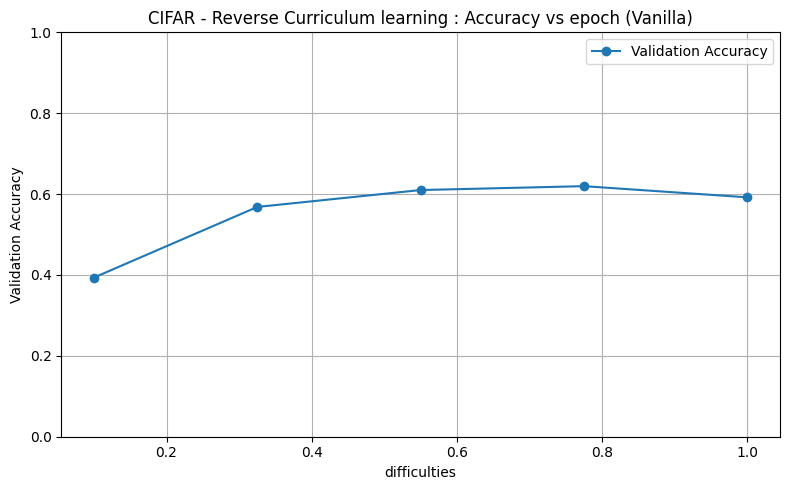

In [41]:
plot_validation_accuracy(
    phases,
    stage_accs,
    x_label="difficulties",
    title="CIFAR - Reverse Curriculum learning : Accuracy vs epoch (Vanilla)",
    convergence_epoch=convergence_idx)

### (5) Stratified Monte-Carlo Sampling

**Stratified Monte Carlo Sampling** is a variance reduction technique where the input space is divided into distinct strata (subregions), and samples are drawn from each stratum. This ensures more uniform coverage of the space compared to standard Monte Carlo sampling, leading to more accurate and stable estimates with fewer samples.

In [11]:
difficulties = compute_cifar_difficulty(train_dataset)
difficulties = (difficulties - difficulties.min()) / (difficulties.max() - difficulties.min())

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 10
num_stages = 5
samples_per_stage = int(len(X_train) / num_stages)

stage_accs = []
val_loss = 0
convergence_idx = -1
prev_val_loss = float('inf')

num_bins = num_stages
bin_edges = np.linspace(0, 1, num_bins + 1)
bins = [[] for _ in range(num_bins)]

for idx, score in enumerate(difficulties):
    for b in range(num_bins):
        if bin_edges[b] <= score < bin_edges[b + 1] or (b == num_bins - 1 and score == 1.0):
            bins[b].append(idx)
            break

for b in bins:
    np.random.shuffle(b)

seen_indices = set()
num_seen = 0

for stage in range(num_stages):

    stage_indices = []

    for b in bins:
        take_n = min(samples_per_stage // num_bins, len(b))
        selected = [i for i in b if i not in seen_indices][:take_n]
        seen_indices.update(selected)
        stage_indices.extend(selected)

    np.random.shuffle(stage_indices)

    X_stage = X_train[stage_indices]
    y_stage = y_train[stage_indices]
    num_seen += len(X_stage)

    print(f"\nStage {stage+1}/{num_stages}: Sampling {len(X_stage)} data points from all difficulty strata ({num_seen}/{len(X_train)})")

    train_dataset_stage = TensorDataset(X_stage, y_stage)
    train_loader_stage = DataLoader(train_dataset_stage, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader_stage:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset_stage)
        print(f"    Epoch {epoch+1}/{epochs_per_stage} - Train Loss: {total_loss/len(train_dataset_stage):.4f}")

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if stage > 0:
        if np.abs(val_loss - prev_val_loss) < epsilon:
            convergence_idx = stage
            print(f"------------ The model has converged at stage {stage} ------------")
            break
        
    prev_val_loss = val_loss
    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total
    stage_accs.append(val_accuracy)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 1/5: Sampling 7424 data points from all difficulty strata (7424/45000)
    Epoch 1/10 - Train Loss: 1.7611
    Epoch 2/10 - Train Loss: 1.3228
    Epoch 3/10 - Train Loss: 1.1089
    Epoch 4/10 - Train Loss: 0.9310
    Epoch 5/10 - Train Loss: 0.7739
    Epoch 6/10 - Train Loss: 0.6187
    Epoch 7/10 - Train Loss: 0.4710
    Epoch 8/10 - Train Loss: 0.3546
    Epoch 9/10 - Train Loss: 0.2206
    Epoch 10/10 - Train Loss: 0.1701

Stage 2/5: Sampling 6042 data points from all difficulty strata (13466/45000)
    Epoch 1/10 - Train Loss: 1.1845
    Epoch 2/10 - Train Loss: 0.7617
    Epoch 3/10 - Train Loss: 0.5361
    Epoch 4/10 - Train Loss: 0.3584
    Epoch 5/10 - Train Loss: 0.2127
    Epoch 6/10 - Train Loss: 0.1191
    Epoch 7/10 - Train Loss: 0.0553
    Epoch 8/10 - Train Loss: 0.0355
    Epoch 9/10 - Train Loss: 0.0188
    Epoch 10/10 - Train Loss: 0.0097

Stage 3/5: Sampling 3675 data points from all difficulty strata (17141/45000)
    Epoch 1/10 - Train Loss: 1.4606
    Ep

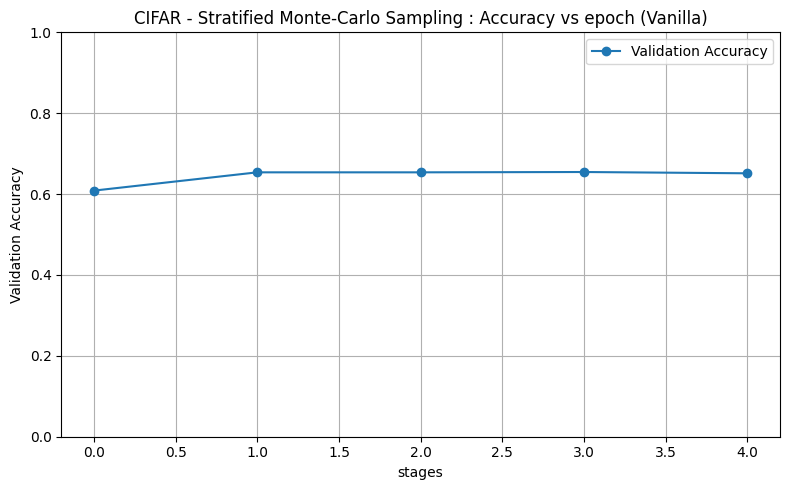

In [12]:
plot_validation_accuracy(
    range(num_stages),
    stage_accs,
    x_label="stages",
    title="CIFAR - Stratified Monte-Carlo Sampling : Accuracy vs epoch (Vanilla)",
    convergence_epoch=convergence_idx)

# CIFAR-10 Dataset with Gaussian Noise

We initialize a range of increasing difficulty.
- 0.0: no noise — easiest samples
- 0.2: very noisy — hardest samples
- 0.25+ usually makes Cifar unreadable

In [3]:
transform = torchvision.transforms.ToTensor()
base_train = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
base_test  = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

full_data = torch.cat([torch.tensor(base_train.data), torch.tensor(base_test.data)], dim=0).float() / 255.0
full_targets = torch.cat([torch.tensor(base_train.targets), torch.tensor(base_test.targets)], dim=0)

full_data = full_data.permute(0, 3, 1, 2)

noise_levels = [0.0, 0.05, 0.1, 0.15, 0.2]
sigma = 0.02

num_samples = full_data.shape[0]
samples_per_level = num_samples // len(noise_levels)
indices = torch.randperm(num_samples)

augmented_data, augmented_targets, noise_labels = [], [], []

for i, level in enumerate(noise_levels):
    start = i * samples_per_level
    end = start + samples_per_level
    idx = indices[start:end]

    data_slice = full_data[idx].clone()
    targets_slice = full_targets[idx]

    if level > 0:
        N, C, H, W = data_slice.shape
        total_pixels = H * W
        num_noisy = int(level * total_pixels)

        for j in range(N):
            coords = torch.randperm(total_pixels)[:num_noisy]
            flat_image = data_slice[j].view(C, -1)
            flat_image[:, coords] += torch.randn(C, num_noisy) * sigma
            flat_image[:, coords].clamp_(0.0, 1.0)

    augmented_data.append(data_slice)
    augmented_targets.append(targets_slice)
    noise_labels.append(torch.full_like(targets_slice, fill_value=i))

augmented_data = torch.cat(augmented_data, dim=0)
augmented_targets = torch.cat(augmented_targets, dim=0)
noise_labels = torch.cat(noise_labels, dim=0)

N_train = len(base_train)
N_test = len(base_test)
train_indices, val_indices = train_test_split(torch.arange(N_train), test_size=0.1, random_state=42, shuffle=True)

X_train = augmented_data[train_indices]
y_train = augmented_targets[train_indices]
noise_levels_train = noise_labels[train_indices]

X_val = augmented_data[val_indices]
y_val = augmented_targets[val_indices]
noise_levels_val = noise_labels[val_indices]

X_test = augmented_data[N_train:]
y_test = augmented_targets[N_train:]
noise_levels_test = noise_labels[N_train:]

# Print dataset shapes
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")
print(f"noise_levels_train: {noise_levels_train.shape}")
print(f"noise_levels_val:   {noise_levels_val.shape}")
print(f"noise_levels_test:  {noise_levels_test.shape}")

Files already downloaded and verified
Files already downloaded and verified
X_train: torch.Size([45000, 3, 32, 32]), y_train: torch.Size([45000])
X_val:   torch.Size([5000, 3, 32, 32]), y_val:   torch.Size([5000])
X_test:  torch.Size([10000, 3, 32, 32]), y_test:  torch.Size([10000])
noise_levels_train: torch.Size([45000])
noise_levels_val:   torch.Size([5000])
noise_levels_test:  torch.Size([10000])


## Analysis

### (0) Base Case

In [ ]:
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # random sampling baseline
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

stage_accs = []
val_loss = 0
convergence_idx = -1

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = total_correct / len(train_dataset)

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if epoch > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = epoch
            val_loss = val_loss_total / val_total
            val_accuracy = val_correct / val_total
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(train_dataset):.4f} - Val Accuracy: {val_accuracy:.4f}")
            print(f"------------ The model has converged at epoch {epoch} ------------")
            stage_accs.append(val_accuracy)
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(train_dataset):.4f} - Val Accuracy: {val_accuracy:.4f}")
    stage_accs.append(val_accuracy)

model.eval()
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        correct += (outputs.argmax(1) == labels).sum().item()
test_acc = correct / len(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/10 - Train Loss: 1.5035 - Val Accuracy: 0.5556
Epoch 2/10 - Train Loss: 1.1493 - Val Accuracy: 0.6062
Epoch 3/10 - Train Loss: 0.9983 - Val Accuracy: 0.6238
Epoch 4/10 - Train Loss: 0.8951 - Val Accuracy: 0.6646
Epoch 5/10 - Train Loss: 0.8171 - Val Accuracy: 0.6792
Epoch 6/10 - Train Loss: 0.7473 - Val Accuracy: 0.6910
Epoch 7/10 - Train Loss: 0.6797 - Val Accuracy: 0.6910
------------ The model has converged at epoch 6 ------------
Test Accuracy: 0.6950


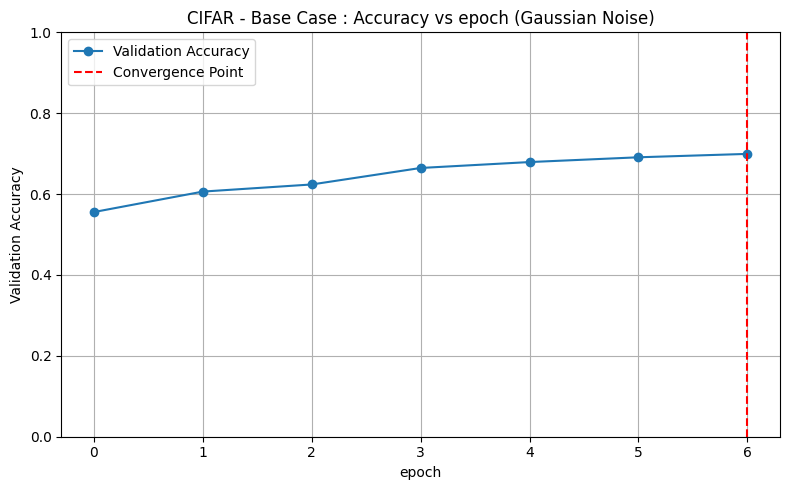

In [12]:
plot_validation_accuracy(
    range(convergence_idx+1),
    stage_accs,
    x_label="epoch",
    title="CIFAR - Base Case : Accuracy vs epoch (Gaussian Noise)",
    convergence_epoch=convergence_idx)

### (1) Curriculum Learning

#### (1.1) Cumulative Curriculum Learning

In [13]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 10
num_stages = 5

stage_accs = []
val_loss = 0
convergence_idx = -1

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Using noise levels <= {stage}")

    stage_mask = noise_levels_train <= stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset_stage = TensorDataset(X_stage, y_stage)
    train_loader_stage = DataLoader(train_dataset_stage, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader_stage:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset_stage)
        print(f"    Epoch {epoch+1}/{epochs_per_stage} - Train Loss: {total_loss/len(train_dataset_stage):.4f}")

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if epoch > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = stage
            print(f"------------ The model has converged at stage {stage} ------------")
            val_accuracy = val_correct / val_total
            stage_accs.append(val_accuracy)
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total

    stage_accs.append(val_accuracy)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 1/5: Using noise levels <= 0
    Epoch 1/10 - Train Loss: 1.8304
    Epoch 2/10 - Train Loss: 1.5267
    Epoch 3/10 - Train Loss: 1.3604
    Epoch 4/10 - Train Loss: 1.2464
    Epoch 5/10 - Train Loss: 1.1635
    Epoch 6/10 - Train Loss: 1.0707
    Epoch 7/10 - Train Loss: 0.9995
    Epoch 8/10 - Train Loss: 0.9350
    Epoch 9/10 - Train Loss: 0.8445
    Epoch 10/10 - Train Loss: 0.7688

Stage 2/5: Using noise levels <= 1
    Epoch 1/10 - Train Loss: 0.9298
    Epoch 2/10 - Train Loss: 0.8272
    Epoch 3/10 - Train Loss: 0.7432
    Epoch 4/10 - Train Loss: 0.6757
    Epoch 5/10 - Train Loss: 0.6028
    Epoch 6/10 - Train Loss: 0.5308
    Epoch 7/10 - Train Loss: 0.4576
    Epoch 8/10 - Train Loss: 0.3942
    Epoch 9/10 - Train Loss: 0.3408
    Epoch 10/10 - Train Loss: 0.2817

Stage 3/5: Using noise levels <= 2
    Epoch 1/10 - Train Loss: 0.6074
    Epoch 2/10 - Train Loss: 0.4758
    Epoch 3/10 - Train Loss: 0.3991
    Epoch 4/10 - Train Loss: 0.3339
    Epoch 5/10 - Train Los

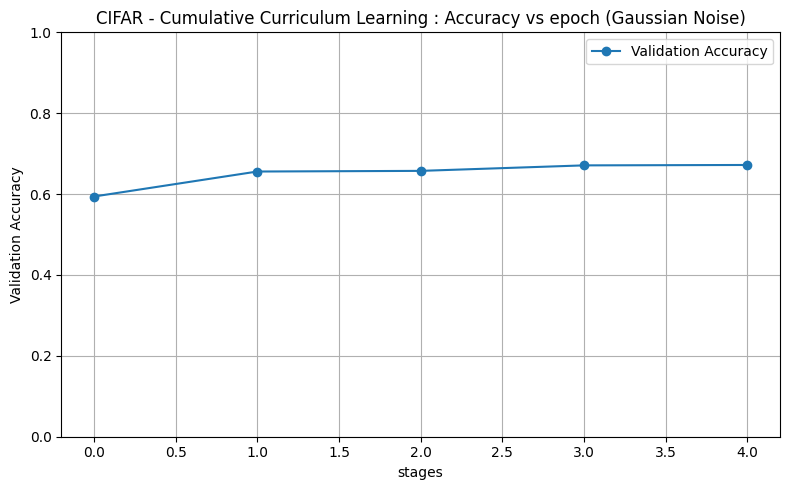

In [14]:
plot_validation_accuracy(
    range(num_stages),
    stage_accs,
    x_label="stages",
    title="CIFAR - Cumulative Curriculum Learning : Accuracy vs epoch (Gaussian Noise)",
    convergence_epoch=convergence_idx)

#### (1.2) Strict Curriculum Learning

In [15]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 10
num_stages = 5

stage_accs = []
val_loss = 0
convergence_idx = -1

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Using noise level {stage}")

    stage_mask = noise_levels_train == stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset_stage = TensorDataset(X_stage, y_stage)
    train_loader_stage = DataLoader(train_dataset_stage, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader_stage:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset_stage)
        print(f"    Epoch {epoch+1}/{epochs_per_stage} - Train Loss: {total_loss/len(train_dataset_stage):.4f}")

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if stage > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = stage
            print(f"------------ The model has converged at stage {stage} ------------")
            val_accuracy = val_correct / val_total
            stage_accs.append(val_accuracy)
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total

    stage_accs.append(val_accuracy)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 1/5: Using noise level 0
    Epoch 1/10 - Train Loss: 1.8434
    Epoch 2/10 - Train Loss: 1.5003
    Epoch 3/10 - Train Loss: 1.3456
    Epoch 4/10 - Train Loss: 1.2292
    Epoch 5/10 - Train Loss: 1.1373
    Epoch 6/10 - Train Loss: 1.0356
    Epoch 7/10 - Train Loss: 0.9525
    Epoch 8/10 - Train Loss: 0.8800
    Epoch 9/10 - Train Loss: 0.8007
    Epoch 10/10 - Train Loss: 0.7221

Stage 2/5: Using noise level 1
    Epoch 1/10 - Train Loss: 1.1088
    Epoch 2/10 - Train Loss: 0.9718
    Epoch 3/10 - Train Loss: 0.8748
    Epoch 4/10 - Train Loss: 0.7905
    Epoch 5/10 - Train Loss: 0.7123
    Epoch 6/10 - Train Loss: 0.6292
    Epoch 7/10 - Train Loss: 0.5471
    Epoch 8/10 - Train Loss: 0.4706
    Epoch 9/10 - Train Loss: 0.3968
    Epoch 10/10 - Train Loss: 0.3198

Stage 3/5: Using noise level 2
    Epoch 1/10 - Train Loss: 1.0923
    Epoch 2/10 - Train Loss: 0.8493
    Epoch 3/10 - Train Loss: 0.7121
    Epoch 4/10 - Train Loss: 0.6169
    Epoch 5/10 - Train Loss: 0.5217
  

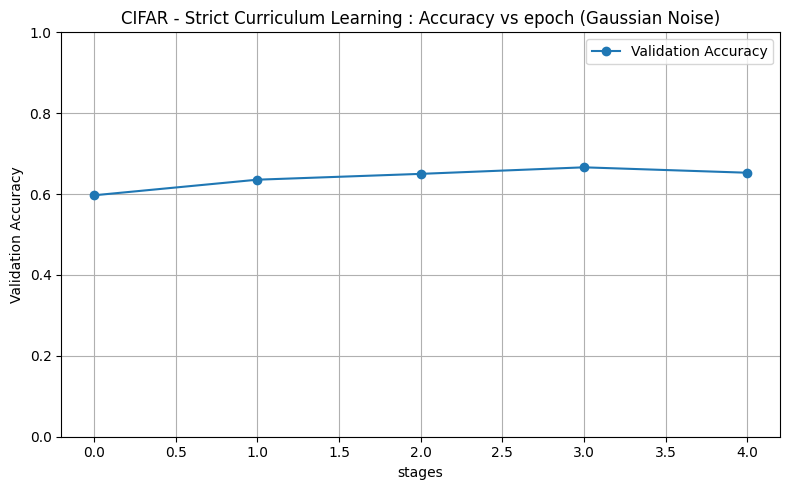

In [16]:
plot_validation_accuracy(
    range(num_stages),
    stage_accs,
    x_label="stages",
    title="CIFAR - Strict Curriculum Learning : Accuracy vs epoch (Gaussian Noise)",
    convergence_epoch=convergence_idx)

### (2) Self-Paced Learning

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='none')  # Important: per-sample loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs = 15
initial_lambda = 2.3  # initial difficulty threshold
lambda_increment = 10  # increase per epoch

stage_accs = []
val_loss = 0
convergence_idx = -1

full_train_dataset = TensorDataset(X_train, y_train)
full_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=False)

for epoch in range(epochs):
    model.eval()
    all_losses = []

    with torch.no_grad():
        for images, labels in full_train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            losses = criterion(outputs, labels)
            all_losses.append(losses.cpu())

    all_losses = torch.cat(all_losses)
    print(torch.min(all_losses))
    print(torch.max(all_losses))

    lambda_threshold = initial_lambda + epoch * lambda_increment

    selected_indices = (all_losses <= lambda_threshold).nonzero(as_tuple=True)[0]

    if len(selected_indices) == 0:
        print(f"Epoch {epoch+1}: No samples selected for training (lambda={lambda_threshold:.3f}), stopping early.")
        break

    print(f"Epoch {epoch+1}: lambda={lambda_threshold:.3f}, selected {len(selected_indices)}/{len(X_train)} samples")

    train_subset = TensorDataset(X_train[selected_indices], y_train[selected_indices])
    train_loader_subset = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

    model.train()
    total_loss, total_correct = 0, 0
    for images, labels in train_loader_subset:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels).mean()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(train_subset)

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels).mean()
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if epoch > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = epoch
            val_loss = val_loss_total / val_total
            val_accuracy = val_correct / val_total
            print(f"    Train Loss: {total_loss/len(train_subset):.4f} - Val Accuracy: {val_accuracy:.4f}")
            print(f"------------ The model has converged at epoch {epoch} ------------")
            stage_accs.append(val_accuracy)
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total

    print(f"    Train Loss: {total_loss/len(train_subset):.4f} - Val Accuracy: {val_accuracy:.4f}")
    stage_accs.append(val_accuracy)


    if len(selected_indices) == len(X_train):
        print(f"  All samples were selected, stopping early.")
        break

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


tensor(2.1796)
tensor(2.4619)
Epoch 1: lambda=2.300, selected 22093/45000 samples
    Train Loss: 1.1701 - Val Accuracy: 0.3530
tensor(0.0003)
tensor(18.8995)
Epoch 2: lambda=12.300, selected 44669/45000 samples
    Train Loss: 1.3656 - Val Accuracy: 0.5674
tensor(0.0005)
tensor(11.2773)
Epoch 3: lambda=22.300, selected 45000/45000 samples
    Train Loss: 1.1114 - Val Accuracy: 0.6138
  All samples were selected, stopping early.

Final Test Accuracy: 0.6198


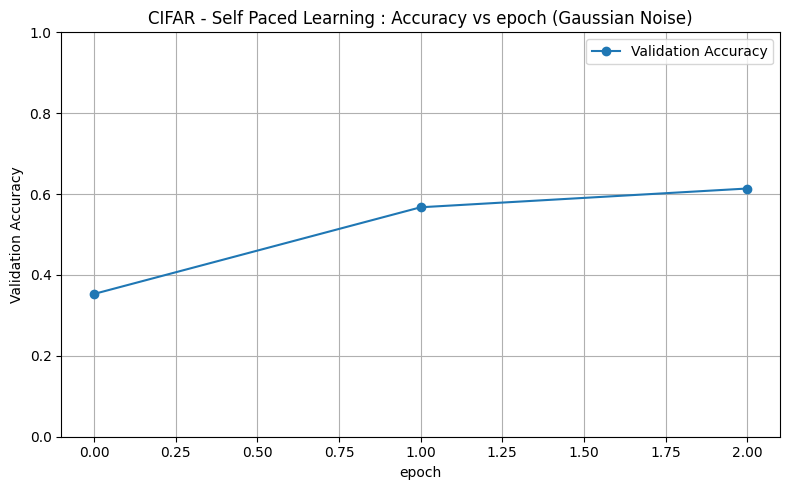

In [21]:
plot_validation_accuracy(
    range(len(stage_accs)),
    stage_accs,
    x_label="epoch",
    title="CIFAR - Self Paced Learning : Accuracy vs epoch (Gaussian Noise)",
    convergence_epoch=convergence_idx)

### (3) Hard-Example Mining

In [22]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs = 10

stage_accs = []
val_loss = 0
convergence_idx = -1

hard_mask = noise_levels_train >= 3

X_hard = X_train[hard_mask]
y_hard = y_train[hard_mask]
print(f"Selected {len(X_hard)} hard examples out of {len(X_train)}")

hard_dataset = TensorDataset(X_hard, y_hard)
hard_loader = DataLoader(hard_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in hard_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(hard_dataset)

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if epoch > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = epoch
            val_loss = val_loss_total / val_total
            val_accuracy = val_correct / val_total
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(hard_dataset):.4f} - Val Accuracy: {val_accuracy:.4f}")
            print(f"------------ The model has converged at epoch {epoch} ------------")
            stage_accs.append(val_accuracy)
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(hard_dataset):.4f} - Val Accuracy: {val_accuracy:.4f}")
    stage_accs.append(val_accuracy)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

Selected 12618 hard examples out of 45000
Epoch 1/10 - Train Loss: 1.8651 - Val Accuracy: 0.4154
Epoch 2/10 - Train Loss: 1.4721 - Val Accuracy: 0.4858
Epoch 3/10 - Train Loss: 1.3049 - Val Accuracy: 0.5284
Epoch 4/10 - Train Loss: 1.1849 - Val Accuracy: 0.5560
Epoch 5/10 - Train Loss: 1.0909 - Val Accuracy: 0.5644
Epoch 6/10 - Train Loss: 1.0012 - Val Accuracy: 0.5716
Epoch 7/10 - Train Loss: 0.9289 - Val Accuracy: 0.5856
Epoch 8/10 - Train Loss: 0.8473 - Val Accuracy: 0.5914
Epoch 9/10 - Train Loss: 0.7863 - Val Accuracy: 0.6182
Epoch 10/10 - Train Loss: 0.7157 - Val Accuracy: 0.6054

Final Test Accuracy: 0.6115


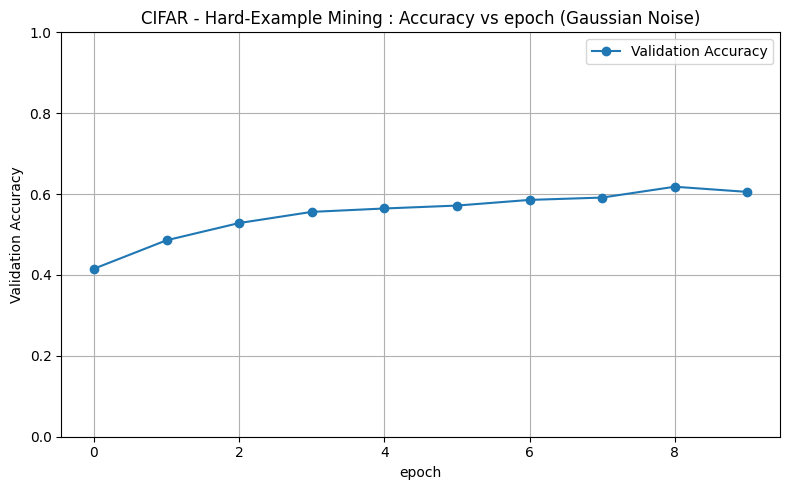

In [23]:
plot_validation_accuracy(
    range(epochs),
    stage_accs,
    x_label="epoch",
    title="CIFAR - Hard-Example Mining : Accuracy vs epoch (Gaussian Noise)",
    convergence_epoch=convergence_idx)

### (4) Reverse Curriculum Learning

#### (4.1) Cumulative Reverse Curriculum Learning

In [ ]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 10
num_stages = 5

stage_accs = []
val_loss = 0
convergence_idx = -1

for stage in reversed(range(num_stages)):
    print(f"\nStage {stage+1}/{num_stages}: Using noise levels >= {stage}")

    stage_mask = noise_levels_train >= stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset_stage = TensorDataset(X_stage, y_stage)
    train_loader_stage = DataLoader(train_dataset_stage, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader_stage:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset_stage)
        print(f"    Epoch {epoch+1}/{epochs_per_stage} - Train Loss: {total_loss/len(train_dataset_stage):.4f}")

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if stage > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = stage
            print(f"------------ The model has converged at stage {stage} ------------")
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total

    stage_accs.append(val_accuracy)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 5/5: Using noise levels >= 4
    Epoch 1/10 - Train Loss: 2.2088
    Epoch 2/10 - Train Loss: 2.0198
    Epoch 3/10 - Train Loss: 1.8125
    Epoch 4/10 - Train Loss: 1.6839
    Epoch 5/10 - Train Loss: 1.6357
    Epoch 6/10 - Train Loss: 1.5258
    Epoch 7/10 - Train Loss: 1.4107
    Epoch 8/10 - Train Loss: 1.3339
    Epoch 9/10 - Train Loss: 1.2363
    Epoch 10/10 - Train Loss: 1.2033

Stage 4/5: Using noise levels >= 3
    Epoch 1/10 - Train Loss: 1.4040
    Epoch 2/10 - Train Loss: 1.2599
    Epoch 3/10 - Train Loss: 1.1538
    Epoch 4/10 - Train Loss: 1.0683
    Epoch 5/10 - Train Loss: 0.9749
    Epoch 6/10 - Train Loss: 0.9005
    Epoch 7/10 - Train Loss: 0.8240
    Epoch 8/10 - Train Loss: 0.7515
    Epoch 9/10 - Train Loss: 0.6795
    Epoch 10/10 - Train Loss: 0.6234

Stage 3/5: Using noise levels >= 2
    Epoch 1/10 - Train Loss: 0.8408
    Epoch 2/10 - Train Loss: 0.7363
    Epoch 3/10 - Train Loss: 0.6705
    Epoch 4/10 - Train Loss: 0.6028
    Epoch 5/10 - Train Los

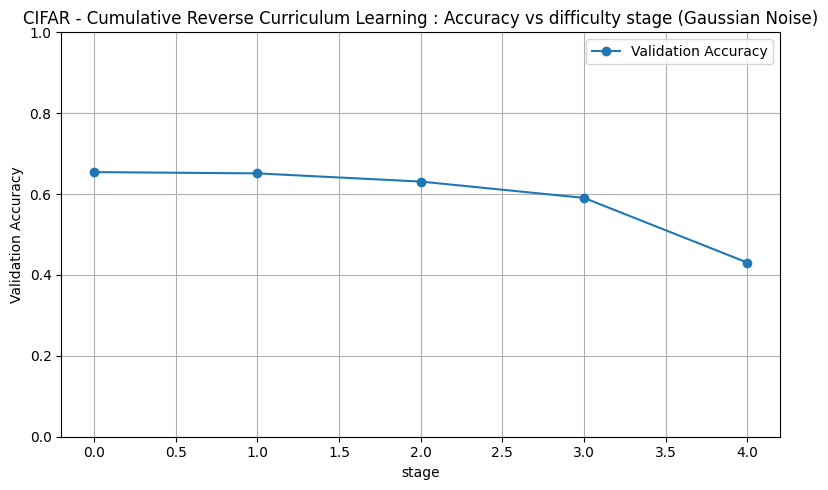

In [26]:
plot_validation_accuracy(
    list(reversed(range(num_stages))),
    stage_accs,
    x_label="stage",
    title="CIFAR - Cumulative Reverse Curriculum Learning : Accuracy vs difficulty stage (Gaussian Noise)",
    convergence_epoch=convergence_idx)

#### (4.2) Strict Reverse Curriculum Learning

In [27]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 10
num_stages = 5

stage_accs = []
val_loss = 0
convergence_idx = -1

for stage in reversed(range(num_stages)):
    print(f"\nStage {stage+1}/{num_stages}: Using noise level {stage}")

    stage_mask = noise_levels_train == stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset_stage = TensorDataset(X_stage, y_stage)
    train_loader_stage = DataLoader(train_dataset_stage, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader_stage:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset_stage)
        print(f"    Epoch {epoch+1}/{epochs_per_stage} - Train Loss: {total_loss/len(train_dataset_stage):.4f}")

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if epoch > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = epoch
            print(f"------------ The model has converged at stage {stage} ------------")
            val_loss = val_loss_total / val_total
            val_accuracy = val_correct / val_total            
            stage_accs.append(val_accuracy)
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total

    
    stage_accs.append(val_accuracy)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 5/5: Using noise level 4
    Epoch 1/10 - Train Loss: 2.2153
    Epoch 2/10 - Train Loss: 1.9084
    Epoch 3/10 - Train Loss: 1.6997
    Epoch 4/10 - Train Loss: 1.5789
    Epoch 5/10 - Train Loss: 1.4941
    Epoch 6/10 - Train Loss: 1.3883
    Epoch 7/10 - Train Loss: 1.3492
    Epoch 8/10 - Train Loss: 1.3150
    Epoch 9/10 - Train Loss: 1.1810
    Epoch 10/10 - Train Loss: 1.1210

Stage 4/5: Using noise level 3
    Epoch 1/10 - Train Loss: 1.4120
    Epoch 2/10 - Train Loss: 1.2599
    Epoch 3/10 - Train Loss: 1.1504
    Epoch 4/10 - Train Loss: 1.0600
    Epoch 5/10 - Train Loss: 0.9630
    Epoch 6/10 - Train Loss: 0.8664
    Epoch 7/10 - Train Loss: 0.7828
    Epoch 8/10 - Train Loss: 0.7134
    Epoch 9/10 - Train Loss: 0.6283
    Epoch 10/10 - Train Loss: 0.5588

Stage 3/5: Using noise level 2
    Epoch 1/10 - Train Loss: 1.1006
    Epoch 2/10 - Train Loss: 0.9082
    Epoch 3/10 - Train Loss: 0.8115
    Epoch 4/10 - Train Loss: 0.7111
    Epoch 5/10 - Train Loss: 0.6244
  

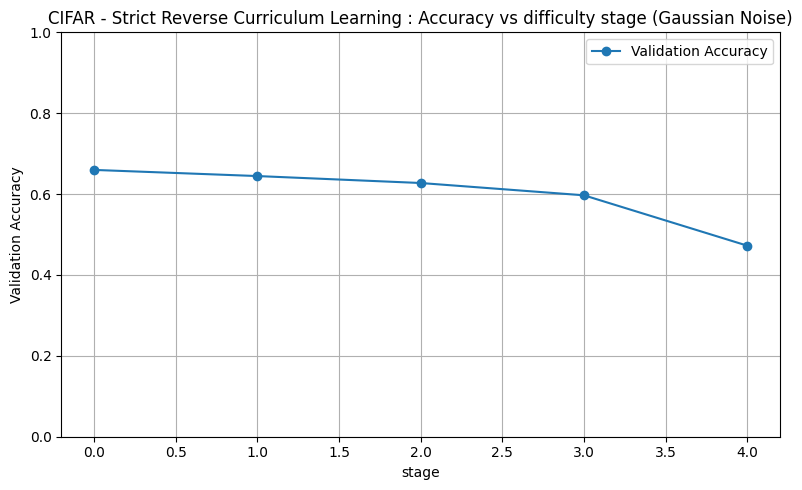

In [28]:
plot_validation_accuracy(
    list(reversed(range(num_stages))),
    stage_accs,
    x_label="stage",
    title="CIFAR - Strict Reverse Curriculum Learning : Accuracy vs difficulty stage (Gaussian Noise)",
    convergence_epoch=convergence_idx)

### (5) Stratified Monte-Carlo Sampling

**Stratified Monte Carlo Sampling** is a variance reduction technique where the input space is divided into distinct strata (subregions), and samples are drawn from each stratum. This ensures more uniform coverage of the space compared to standard Monte Carlo sampling, leading to more accurate and stable estimates with fewer samples.

In [29]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 10
num_stages = 5
samples_per_stage = 10000

stage_accs = []
val_loss = 0
convergence_idx = -1

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Sampling from stage level = {stage}")

    stage_mask = (noise_levels_train == stage).nonzero(as_tuple=True)[0]

    # Randomly sample without replacement
    if len(stage_mask) < samples_per_stage:
        print(f"  Warning: only {len(stage_mask)} samples available, using all.")
        selected_indices = stage_mask
    else:
        selected_indices = stage_mask[torch.randperm(len(stage_mask))[:samples_per_stage]]

    X_stage = X_train[selected_indices]
    y_stage = y_train[selected_indices]
    train_dataset_stage = TensorDataset(X_stage, y_stage)
    train_loader_stage = DataLoader(train_dataset_stage, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader_stage:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset_stage)
        print(f"    Epoch {epoch+1}/{epochs_per_stage} - Train Loss: {total_loss/len(train_dataset_stage):.4f}")

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if stage > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = stage
            print(f"------------ The model has converged at stage {stage} ------------")
            val_loss = val_loss_total / val_total
            val_accuracy = val_correct / val_total
            stage_accs.append(val_accuracy)
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total
    
    stage_accs.append(val_accuracy)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 1/5: Sampling from stage level = 0
    Epoch 1/10 - Train Loss: 1.8513
    Epoch 2/10 - Train Loss: 1.5177
    Epoch 3/10 - Train Loss: 1.3520
    Epoch 4/10 - Train Loss: 1.2371
    Epoch 5/10 - Train Loss: 1.1368
    Epoch 6/10 - Train Loss: 1.0435
    Epoch 7/10 - Train Loss: 0.9656
    Epoch 8/10 - Train Loss: 0.9023
    Epoch 9/10 - Train Loss: 0.8075
    Epoch 10/10 - Train Loss: 0.7313

Stage 2/5: Sampling from stage level = 1
    Epoch 1/10 - Train Loss: 1.1260
    Epoch 2/10 - Train Loss: 0.9634
    Epoch 3/10 - Train Loss: 0.8774
    Epoch 4/10 - Train Loss: 0.7843
    Epoch 5/10 - Train Loss: 0.7127
    Epoch 6/10 - Train Loss: 0.6258
    Epoch 7/10 - Train Loss: 0.5399
    Epoch 8/10 - Train Loss: 0.4712
    Epoch 9/10 - Train Loss: 0.3917
    Epoch 10/10 - Train Loss: 0.3498

Stage 3/5: Sampling from stage level = 2
    Epoch 1/10 - Train Loss: 1.0568
    Epoch 2/10 - Train Loss: 0.8250
    Epoch 3/10 - Train Loss: 0.7002
    Epoch 4/10 - Train Loss: 0.5964
    Epoc

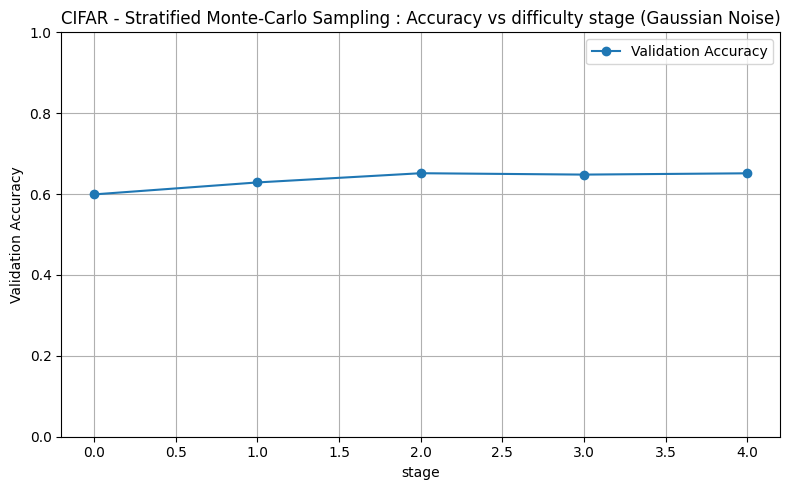

In [30]:
plot_validation_accuracy(
    range(num_stages),
    stage_accs,
    x_label="stage",
    title="CIFAR - Stratified Monte-Carlo Sampling : Accuracy vs difficulty stage (Gaussian Noise)",
    convergence_epoch=convergence_idx)

# CIFAR-10 Dataset with Impulse Noise

We initialize a range of increasing difficulty.
- 0.0: no noise — easiest samples
- 0.2: very noisy — hardest samples
- 0.25+ usually makes Cifar unreadable

In [31]:
transform = transforms.ToTensor()
base_train = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
base_test = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

full_data = torch.cat([torch.tensor(base_train.data), torch.tensor(base_test.data)], dim=0).float() / 255.0
full_targets = torch.cat([torch.tensor(base_train.targets), torch.tensor(base_test.targets)], dim=0)

full_data = full_data.permute(0, 3, 1, 2)

noise_levels = [0.0, 0.05, 0.1, 0.15, 0.2]
sigma = 0.02
num_samples = full_data.shape[0]
samples_per_level = num_samples // len(noise_levels)

indices = torch.randperm(num_samples)

augmented_data, augmented_targets, noise_labels = [], [], []

for i, level in enumerate(noise_levels):
    start = i * samples_per_level
    end = start + samples_per_level
    idx = indices[start:end]

    data_slice = full_data[idx].clone()
    targets_slice = full_targets[idx]

    if level > 0:
        N, C, H, W = data_slice.shape
        total_pixels = H * W
        num_noisy = int(level * total_pixels)

        for j in range(N):
            coords = torch.randperm(total_pixels)[:num_noisy]
            flat_image = data_slice[j].view(C, -1)
            flat_image[:, coords] = torch.randint(0, 2, (C, num_noisy), dtype=torch.float32)
            flat_image[:, coords].clamp_(0.0, 1.0)

    augmented_data.append(data_slice)
    augmented_targets.append(targets_slice)
    noise_labels.append(torch.full_like(targets_slice, fill_value=i))

augmented_data = torch.cat(augmented_data)
augmented_targets = torch.cat(augmented_targets)
noise_labels = torch.cat(noise_labels)

N_train = len(base_train)
N_test = len(base_test)

val_size = int(0.1 * N_train)
train_size = N_train - val_size
train_indices, val_indices = random_split(torch.arange(N_train), [train_size, val_size], generator=torch.Generator().manual_seed(42))

# Create final splits
X_train = augmented_data[train_indices]
y_train = augmented_targets[train_indices]
noise_levels_train = noise_labels[train_indices]

X_val = augmented_data[val_indices]
y_val = augmented_targets[val_indices]
noise_levels_val = noise_labels[val_indices]

X_test = augmented_data[N_train:]
y_test = augmented_targets[N_train:]
noise_levels_test = noise_labels[N_train:]

# Print shapes
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")
print(f"noise_levels_train shape: {noise_levels_train.shape}")
print(f"noise_levels_val shape:   {noise_levels_val.shape}")
print(f"noise_levels_test shape:  {noise_levels_test.shape}")

Files already downloaded and verified
Files already downloaded and verified
X_train: torch.Size([45000, 3, 32, 32]), y_train: torch.Size([45000])
X_val:   torch.Size([5000, 3, 32, 32]), y_val:   torch.Size([5000])
X_test:  torch.Size([10000, 3, 32, 32]), y_test:  torch.Size([10000])
noise_levels_train shape: torch.Size([45000])
noise_levels_val shape:   torch.Size([5000])
noise_levels_test shape:  torch.Size([10000])


## Analysis

### (0) Base Case

In [ ]:
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # random sampling baseline
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
stage_accs = []
val_loss = 0
convergence_idx = -1

for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    train_acc = total_correct / len(train_dataset)

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if epoch > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = epoch
            val_loss = val_loss_total / val_total
            val_accuracy = val_correct / val_total
            stage_accs.append(val_accuracy)
            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(train_dataset):.4f} - Val Accuracy: {val_accuracy:.4f}")
            print(f"------------ The model has converged at epoch {epoch+1} ------------")
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(train_dataset):.4f} - Val Accuracy: {val_accuracy:.4f}")
    stage_accs.append(val_accuracy)

model.eval()
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        correct += (outputs.argmax(1) == labels).sum().item()
test_acc = correct / len(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/10 - Train Loss: 1.6644 - Val Accuracy: 0.4940
Epoch 2/10 - Train Loss: 1.3424 - Val Accuracy: 0.5360
Epoch 3/10 - Train Loss: 1.2224 - Val Accuracy: 0.5956
Epoch 4/10 - Train Loss: 1.1340 - Val Accuracy: 0.6208
Epoch 5/10 - Train Loss: 1.0567 - Val Accuracy: 0.6488
Epoch 6/10 - Train Loss: 0.9917 - Val Accuracy: 0.6552
Epoch 7/10 - Train Loss: 0.9270 - Val Accuracy: 0.6714
Epoch 8/10 - Train Loss: 0.8735 - Val Accuracy: 0.6806
Epoch 9/10 - Train Loss: 0.8216 - Val Accuracy: 0.7014
Epoch 10/10 - Train Loss: 0.7724 - Val Accuracy: 0.7076
------------ The model has converged at epoch 9 ------------
Test Accuracy: 0.5334


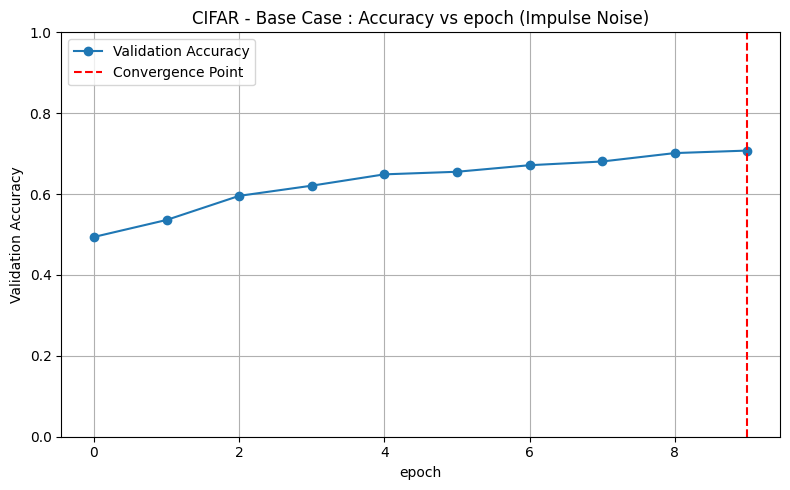

In [35]:
plot_validation_accuracy(
    range(len(stage_accs)),
    stage_accs,
    x_label="epoch",
    title="CIFAR - Base Case : Accuracy vs epoch (Impulse Noise)",
    convergence_epoch=convergence_idx)

### (1) Curriculum Learning

#### (1.1) Cumulative Curriculum Learning

In [36]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 10
num_stages = 5
stage_accs = []
val_loss = 0
convergence_idx = -1

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Using noise levels <= {stage}")

    stage_mask = noise_levels_train <= stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset_stage = TensorDataset(X_stage, y_stage)
    train_loader_stage = DataLoader(train_dataset_stage, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader_stage:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset_stage)
        print(f"    Epoch {epoch+1}/{epochs_per_stage} - Train Loss: {total_loss/len(train_dataset_stage):.4f}")

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if stage > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = stage
            val_loss = val_loss_total / val_total
            val_accuracy = val_correct / val_total
            stage_accs.append(val_accuracy)
            print(f"------------ The model has converged at stage {stage} ------------")
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total

    stage_accs.append(val_accuracy)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 1/5: Using noise levels <= 0
    Epoch 1/10 - Train Loss: 1.8578
    Epoch 2/10 - Train Loss: 1.4876
    Epoch 3/10 - Train Loss: 1.3369
    Epoch 4/10 - Train Loss: 1.2248
    Epoch 5/10 - Train Loss: 1.1223
    Epoch 6/10 - Train Loss: 1.0276
    Epoch 7/10 - Train Loss: 0.9463
    Epoch 8/10 - Train Loss: 0.8556
    Epoch 9/10 - Train Loss: 0.7686
    Epoch 10/10 - Train Loss: 0.6882

Stage 2/5: Using noise levels <= 1
    Epoch 1/10 - Train Loss: 0.9808
    Epoch 2/10 - Train Loss: 0.8466
    Epoch 3/10 - Train Loss: 0.7488
    Epoch 4/10 - Train Loss: 0.6563
    Epoch 5/10 - Train Loss: 0.5607
    Epoch 6/10 - Train Loss: 0.4769
    Epoch 7/10 - Train Loss: 0.3961
    Epoch 8/10 - Train Loss: 0.3186
    Epoch 9/10 - Train Loss: 0.2521
    Epoch 10/10 - Train Loss: 0.2044

Stage 3/5: Using noise levels <= 2
    Epoch 1/10 - Train Loss: 0.6643
    Epoch 2/10 - Train Loss: 0.4978
    Epoch 3/10 - Train Loss: 0.3974
    Epoch 4/10 - Train Loss: 0.3153
    Epoch 5/10 - Train Los

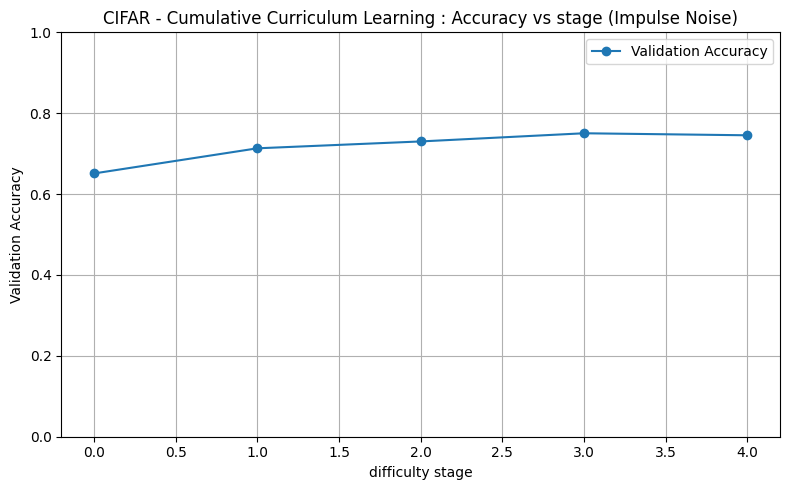

In [37]:
plot_validation_accuracy(
    range(num_stages),
    stage_accs,
    x_label="difficulty stage",
    title="CIFAR - Cumulative Curriculum Learning : Accuracy vs stage (Impulse Noise)",
    convergence_epoch=convergence_idx)

#### (1.2) Strict Curriculum Learning

In [38]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 10
num_stages = 5
stage_accs = []
val_loss = 0
convergence_idx = -1

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Using noise level {stage}")

    stage_mask = noise_levels_train == stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset_stage = TensorDataset(X_stage, y_stage)
    train_loader_stage = DataLoader(train_dataset_stage, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader_stage:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset_stage)
        print(f"    Epoch {epoch+1}/{epochs_per_stage} - Train Loss: {total_loss/len(train_dataset_stage):.4f}")

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if stage > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = stage
            val_loss = val_loss_total / val_total
            val_accuracy = val_correct / val_total
            stage_accs.append(val_accuracy)
            print(f"------------ The model has converged at stage {stage} ------------")
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total

    stage_accs.append(val_accuracy)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 1/5: Using noise level 0
    Epoch 1/10 - Train Loss: 1.9256
    Epoch 2/10 - Train Loss: 1.5543
    Epoch 3/10 - Train Loss: 1.4027
    Epoch 4/10 - Train Loss: 1.2759
    Epoch 5/10 - Train Loss: 1.1822
    Epoch 6/10 - Train Loss: 1.0965
    Epoch 7/10 - Train Loss: 1.0282
    Epoch 8/10 - Train Loss: 0.9628
    Epoch 9/10 - Train Loss: 0.9036
    Epoch 10/10 - Train Loss: 0.8479

Stage 2/5: Using noise level 1
    Epoch 1/10 - Train Loss: 1.2868
    Epoch 2/10 - Train Loss: 1.1411
    Epoch 3/10 - Train Loss: 1.0400
    Epoch 4/10 - Train Loss: 0.9491
    Epoch 5/10 - Train Loss: 0.8679
    Epoch 6/10 - Train Loss: 0.7894
    Epoch 7/10 - Train Loss: 0.6916
    Epoch 8/10 - Train Loss: 0.6186
    Epoch 9/10 - Train Loss: 0.5368
    Epoch 10/10 - Train Loss: 0.4603

Stage 3/5: Using noise level 2
    Epoch 1/10 - Train Loss: 1.3008
    Epoch 2/10 - Train Loss: 1.0766
    Epoch 3/10 - Train Loss: 0.9521
    Epoch 4/10 - Train Loss: 0.8459
    Epoch 5/10 - Train Loss: 0.7366
  

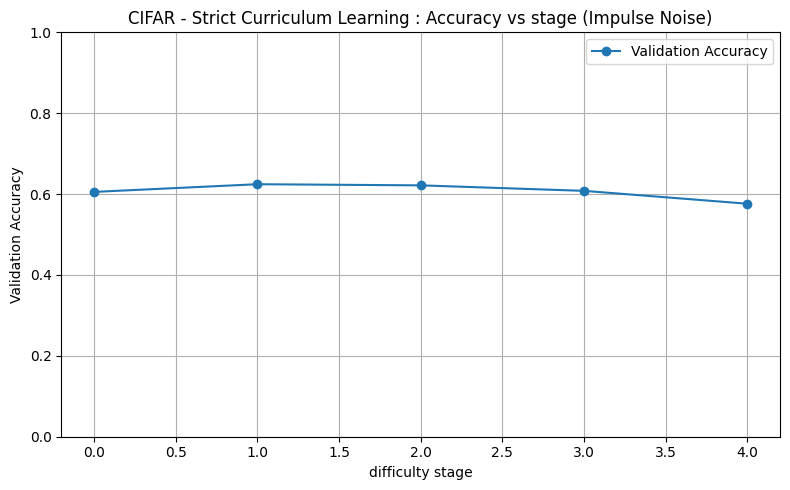

In [39]:
plot_validation_accuracy(
    range(num_stages),
    stage_accs,
    x_label="difficulty stage",
    title="CIFAR - Strict Curriculum Learning : Accuracy vs stage (Impulse Noise)",
    convergence_epoch=convergence_idx)

### (2) Self-Paced Learning

In [41]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 6
samples_per_epoch = len(X_train) // num_epochs

seen_mask = torch.zeros(len(X_train), dtype=torch.bool)

stage_accs = []
val_loss = 0
convergence_idx = -1

for epoch in range(num_epochs):
    model.eval()
    with torch.no_grad():
        unseen_indices = (~seen_mask).nonzero(as_tuple=True)[0]
        unseen_loader = DataLoader(TensorDataset(X_train[unseen_indices], y_train[unseen_indices]),
                                   batch_size=batch_size, shuffle=False)
        if len(unseen_indices)==0:
          break

        all_losses = []
        for images, labels in unseen_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            losses = criterion(outputs, labels)
            all_losses.append(losses.cpu())

        all_losses = torch.cat(all_losses)

    k = min(samples_per_epoch, len(unseen_indices))
    selected_in_unseen = torch.topk(-all_losses, k).indices
    selected_indices = unseen_indices[selected_in_unseen]

    seen_mask[selected_indices] = True

    print(f"Epoch {epoch+1}/{num_epochs}: selected {len(selected_indices)} new samples (total seen: {seen_mask.sum().item()}/{len(X_train)})")

    train_loader_stage = DataLoader(TensorDataset(X_train[selected_indices], y_train[selected_indices]),
                              batch_size=batch_size, shuffle=True)

    model.train()
    total_loss, total_correct = 0, 0
    for images, labels in train_loader_stage:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels).mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(labels)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(train_loader_stage.dataset)

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels).mean()
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if epoch > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = epoch
            val_loss = val_loss_total / val_total
            val_accuracy = val_correct / val_total
            print(f"    Train Loss: {total_loss/len(train_loader_stage.dataset):.4f} - Val Accuracy: {val_accuracy:.4f}")
            print(f"------------ The model has converged at epoch {epoch} ------------")
            stage_accs.append(val_accuracy)
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total

    print(f"    Train Loss: {total_loss/len(train_loader_stage.dataset):.4f} - Val Accuracy: {val_accuracy:.4f}")
    stage_accs.append(val_accuracy)

print("Training complete.")

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

Epoch 1/6: selected 7500 new samples (total seen: 7500/45000)
    Train Loss: 0.7110 - Val Accuracy: 0.1568
Epoch 2/6: selected 7500 new samples (total seen: 15000/45000)
    Train Loss: 0.9474 - Val Accuracy: 0.1694
Epoch 3/6: selected 7500 new samples (total seen: 22500/45000)
    Train Loss: 1.5766 - Val Accuracy: 0.1936
Epoch 4/6: selected 7500 new samples (total seen: 30000/45000)
    Train Loss: 0.5743 - Val Accuracy: 0.2108
Epoch 5/6: selected 7500 new samples (total seen: 37500/45000)
    Train Loss: 1.3408 - Val Accuracy: 0.2276
Epoch 6/6: selected 7500 new samples (total seen: 45000/45000)
    Train Loss: 1.1437 - Val Accuracy: 0.1952
Training complete.

Final Test Accuracy: 0.1491


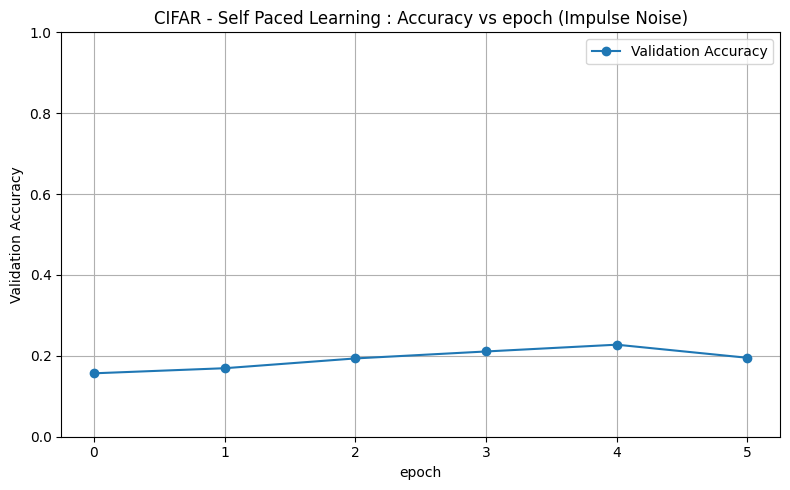

In [43]:
plot_validation_accuracy(
    range(num_epochs),
    stage_accs,
    x_label="epoch",
    title="CIFAR - Self Paced Learning : Accuracy vs epoch (Impulse Noise)",
    convergence_epoch=convergence_idx)

### (3) Hard-Example Mining

In [53]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs = 10
stage_accs = []
val_loss = 0
convergence_idx = -1

hard_mask = noise_levels_train >= 3

X_hard = X_train[hard_mask]
y_hard = y_train[hard_mask]
print(f"Selected {len(X_hard)} hard examples out of {len(X_train)}")

hard_dataset = TensorDataset(X_hard, y_hard)
hard_loader = DataLoader(hard_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for images, labels in hard_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    acc = total_correct / len(hard_dataset)

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if epoch > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = epoch
            val_loss = val_loss_total / val_total
            val_accuracy = val_correct / val_total

            print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(hard_dataset):.4f} - Val Accuracy: {val_accuracy:.4f}")
            stage_accs.append(val_accuracy)
            print(f"------------ The model has converged at epoch {epoch} ------------")
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {total_loss/len(hard_dataset):.4f} - Val Accuracy: {val_accuracy:.4f}")
    stage_accs.append(val_accuracy)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")

Selected 12582 hard examples out of 45000
Epoch 1/10 - Train Loss: 2.0012 - Val Accuracy: 0.3486
Epoch 2/10 - Train Loss: 1.7357 - Val Accuracy: 0.3846
Epoch 3/10 - Train Loss: 1.5991 - Val Accuracy: 0.4330
Epoch 4/10 - Train Loss: 1.4979 - Val Accuracy: 0.4808
Epoch 5/10 - Train Loss: 1.4164 - Val Accuracy: 0.4968
Epoch 6/10 - Train Loss: 1.3256 - Val Accuracy: 0.5134
Epoch 7/10 - Train Loss: 1.2585 - Val Accuracy: 0.5224
Epoch 8/10 - Train Loss: 1.1893 - Val Accuracy: 0.5294
Epoch 9/10 - Train Loss: 1.1241 - Val Accuracy: 0.5316
Epoch 10/10 - Train Loss: 1.0484 - Val Accuracy: 0.5376

Final Test Accuracy: 0.4909


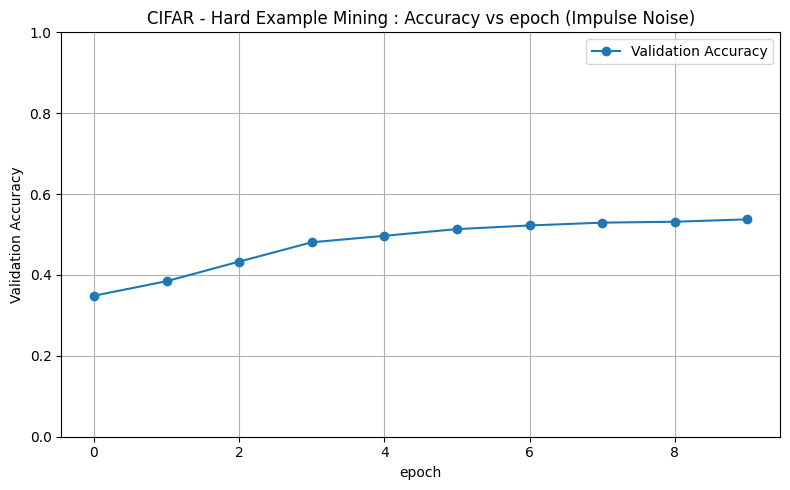

In [54]:
plot_validation_accuracy(
    range(epochs),
    stage_accs,
    x_label="epoch",
    title="CIFAR - Hard Example Mining : Accuracy vs epoch (Impulse Noise)",
    convergence_epoch=convergence_idx)

### (4) Reverse Curriculum Learning

#### (4.1) Cumulative Reverse Curriculum Learning

In [55]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 10
num_stages = 5
stage_accs = []
val_loss = 0
convergence_idx = -1

for stage in reversed(range(num_stages)):
    print(f"\nStage {stage+1}/{num_stages}: Using noise levels >= {stage}")

    stage_mask = noise_levels_train >= stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset_stage = TensorDataset(X_stage, y_stage)
    train_loader_stage = DataLoader(train_dataset_stage, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader_stage:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset_stage)
        print(f"    Epoch {epoch+1}/{epochs_per_stage} - Train Loss: {total_loss/len(train_dataset_stage):.4f}")

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if stage > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = stage
            val_loss = val_loss_total / val_total
            val_accuracy = val_correct / val_total
            stage_accs.append(val_accuracy)
            print(f"------------ The model has converged at stage {stage} ------------")
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total
    stage_accs.append(val_accuracy)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 5/5: Using noise levels >= 4
    Epoch 1/10 - Train Loss: 2.2601
    Epoch 2/10 - Train Loss: 2.0517
    Epoch 3/10 - Train Loss: 1.9496
    Epoch 4/10 - Train Loss: 1.8709
    Epoch 5/10 - Train Loss: 1.7852
    Epoch 6/10 - Train Loss: 1.7229
    Epoch 7/10 - Train Loss: 1.6235
    Epoch 8/10 - Train Loss: 1.5428
    Epoch 9/10 - Train Loss: 1.4616
    Epoch 10/10 - Train Loss: 1.4424

Stage 4/5: Using noise levels >= 3
    Epoch 1/10 - Train Loss: 1.6563
    Epoch 2/10 - Train Loss: 1.5110
    Epoch 3/10 - Train Loss: 1.4180
    Epoch 4/10 - Train Loss: 1.3211
    Epoch 5/10 - Train Loss: 1.2293
    Epoch 6/10 - Train Loss: 1.1304
    Epoch 7/10 - Train Loss: 1.0429
    Epoch 8/10 - Train Loss: 0.9389
    Epoch 9/10 - Train Loss: 0.8354
    Epoch 10/10 - Train Loss: 0.7331

Stage 3/5: Using noise levels >= 2
    Epoch 1/10 - Train Loss: 1.0306
    Epoch 2/10 - Train Loss: 0.9084
    Epoch 3/10 - Train Loss: 0.8208
    Epoch 4/10 - Train Loss: 0.7276
    Epoch 5/10 - Train Los

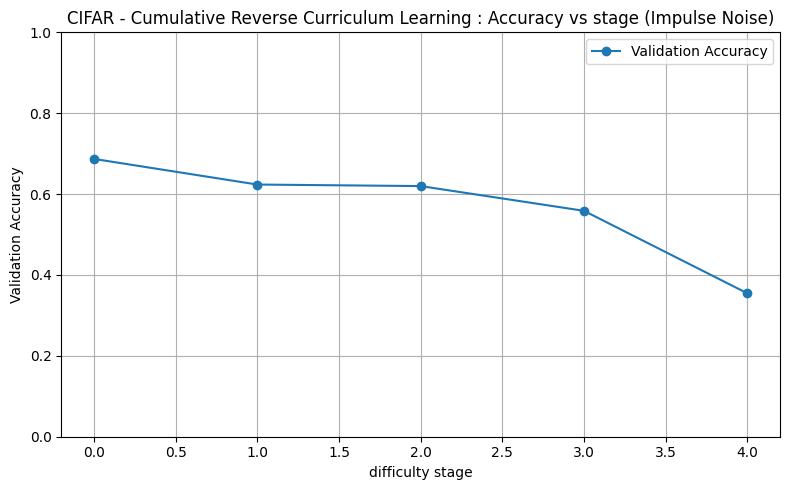

In [56]:
plot_validation_accuracy(
    list(reversed(range(num_stages))),
    stage_accs,
    x_label="difficulty stage",
    title="CIFAR - Cumulative Reverse Curriculum Learning : Accuracy vs stage (Impulse Noise)",
    convergence_epoch=convergence_idx)

#### (4.2) Strict Reverse Curriculum Learning

In [57]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 10
num_stages = 5
stage_accs = []
val_loss = 0
convergence_idx = -1

for stage in reversed(range(num_stages)):
    print(f"\nStage {stage+1}/{num_stages}: Using noise level {stage}")

    stage_mask = noise_levels_train == stage
    X_stage = X_train[stage_mask]
    y_stage = y_train[stage_mask]

    train_dataset_stage = TensorDataset(X_stage, y_stage)
    train_loader_stage = DataLoader(train_dataset_stage, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader_stage:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset_stage)
        print(f"    Epoch {epoch+1}/{epochs_per_stage} - Train Loss: {total_loss/len(train_dataset_stage):.4f}")

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if stage > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = stage
            val_loss = val_loss_total / val_total
            val_accuracy = val_correct / val_total
            stage_accs.append(val_accuracy)
            print(f"------------ The model has converged at stage {stage} ------------")
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total
    stage_accs.append(val_accuracy)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 5/5: Using noise level 4
    Epoch 1/10 - Train Loss: 2.2914
    Epoch 2/10 - Train Loss: 2.1319
    Epoch 3/10 - Train Loss: 1.9779
    Epoch 4/10 - Train Loss: 1.9199
    Epoch 5/10 - Train Loss: 1.8354
    Epoch 6/10 - Train Loss: 1.8051
    Epoch 7/10 - Train Loss: 1.7335
    Epoch 8/10 - Train Loss: 1.6881
    Epoch 9/10 - Train Loss: 1.6065
    Epoch 10/10 - Train Loss: 1.5629

Stage 4/5: Using noise level 3
    Epoch 1/10 - Train Loss: 1.7136
    Epoch 2/10 - Train Loss: 1.5688
    Epoch 3/10 - Train Loss: 1.4780
    Epoch 4/10 - Train Loss: 1.4110
    Epoch 5/10 - Train Loss: 1.3533
    Epoch 6/10 - Train Loss: 1.2961
    Epoch 7/10 - Train Loss: 1.2244
    Epoch 8/10 - Train Loss: 1.1708
    Epoch 9/10 - Train Loss: 1.1017
    Epoch 10/10 - Train Loss: 1.0485

Stage 3/5: Using noise level 2
    Epoch 1/10 - Train Loss: 1.3645
    Epoch 2/10 - Train Loss: 1.2499
    Epoch 3/10 - Train Loss: 1.1796
    Epoch 4/10 - Train Loss: 1.1165
    Epoch 5/10 - Train Loss: 1.0590
  

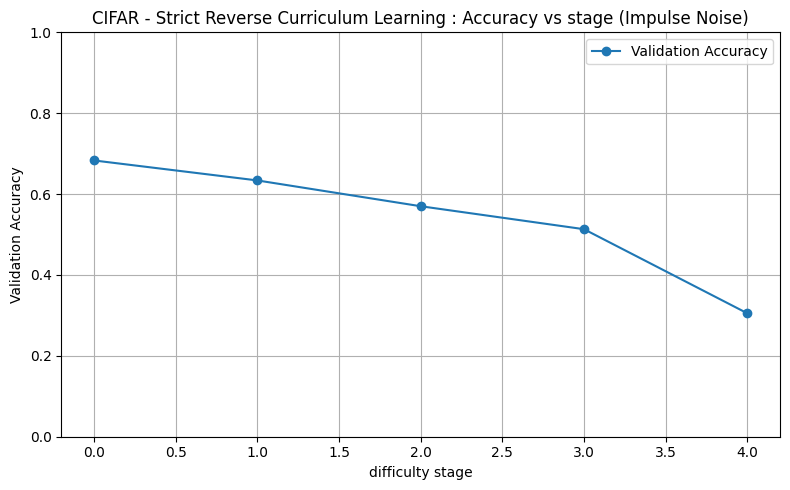

In [58]:
plot_validation_accuracy(
    list(reversed(range(num_stages))),
    stage_accs,
    x_label="difficulty stage",
    title="CIFAR - Strict Reverse Curriculum Learning : Accuracy vs stage (Impulse Noise)",
    convergence_epoch=convergence_idx)

### (5) Stratified Monte-Carlo Sampling

**Stratified Monte Carlo Sampling** is a variance reduction technique where the input space is divided into distinct strata (subregions), and samples are drawn from each stratum. This ensures more uniform coverage of the space compared to standard Monte Carlo sampling, leading to more accurate and stable estimates with fewer samples.

In [51]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = SmallCNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

batch_size = 64
epochs_per_stage = 10
num_stages = 5
samples_per_stage = 10000
stage_accs = []
val_loss = 0
convergence_idx = -1

for stage in range(num_stages):
    print(f"\nStage {stage+1}/{num_stages}: Sampling from stage level = {stage}")

    stage_mask = (noise_levels_train == stage).nonzero(as_tuple=True)[0]

    # Randomly sample without replacement
    if len(stage_mask) < samples_per_stage:
        print(f"  Warning: only {len(stage_mask)} samples available, using all.")
        selected_indices = stage_mask
    else:
        selected_indices = stage_mask[torch.randperm(len(stage_mask))[:samples_per_stage]]

    X_stage = X_train[selected_indices]
    y_stage = y_train[selected_indices]
    train_dataset_stage = TensorDataset(X_stage, y_stage)
    train_loader_stage = DataLoader(train_dataset_stage, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs_per_stage):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader_stage:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

        acc = total_correct / len(train_dataset_stage)
        print(f"    Epoch {epoch+1}/{epochs_per_stage} - Train Loss: {total_loss/len(train_dataset_stage):.4f}")

    # VALIDATION
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_loss_total += loss.item() * images.size(0)

            predicted = outputs.argmax(dim=1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    if stage > 0:
        if np.abs(val_loss - (val_loss_total/val_total)) < epsilon:
            convergence_idx = stage
            val_loss = val_loss_total / val_total
            val_accuracy = val_correct / val_total
            stage_accs.append(val_accuracy)
            
            print(f"------------ The model has converged at stage {stage} ------------")
            break

    val_loss = val_loss_total / val_total
    val_accuracy = val_correct / val_total
    stage_accs.append(val_accuracy)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

model.eval()
total_correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        total_correct += (outputs.argmax(1) == labels).sum().item()

test_acc = total_correct / len(test_dataset)
print(f"\nFinal Test Accuracy: {test_acc:.4f}")


Stage 1/5: Sampling from stage level = 0
    Epoch 1/10 - Train Loss: 1.8931
    Epoch 2/10 - Train Loss: 1.5238
    Epoch 3/10 - Train Loss: 1.3986
    Epoch 4/10 - Train Loss: 1.2940
    Epoch 5/10 - Train Loss: 1.2227
    Epoch 6/10 - Train Loss: 1.1595
    Epoch 7/10 - Train Loss: 1.0830
    Epoch 8/10 - Train Loss: 1.0076
    Epoch 9/10 - Train Loss: 0.9764
    Epoch 10/10 - Train Loss: 0.9011

Stage 2/5: Sampling from stage level = 1
    Epoch 1/10 - Train Loss: 1.2897
    Epoch 2/10 - Train Loss: 1.1373
    Epoch 3/10 - Train Loss: 1.0478
    Epoch 4/10 - Train Loss: 0.9663
    Epoch 5/10 - Train Loss: 0.8840
    Epoch 6/10 - Train Loss: 0.7978
    Epoch 7/10 - Train Loss: 0.7142
    Epoch 8/10 - Train Loss: 0.6339
    Epoch 9/10 - Train Loss: 0.5541
    Epoch 10/10 - Train Loss: 0.4740

Stage 3/5: Sampling from stage level = 2
    Epoch 1/10 - Train Loss: 1.3035
    Epoch 2/10 - Train Loss: 1.0795
    Epoch 3/10 - Train Loss: 0.9534
    Epoch 4/10 - Train Loss: 0.8293
    Epoc

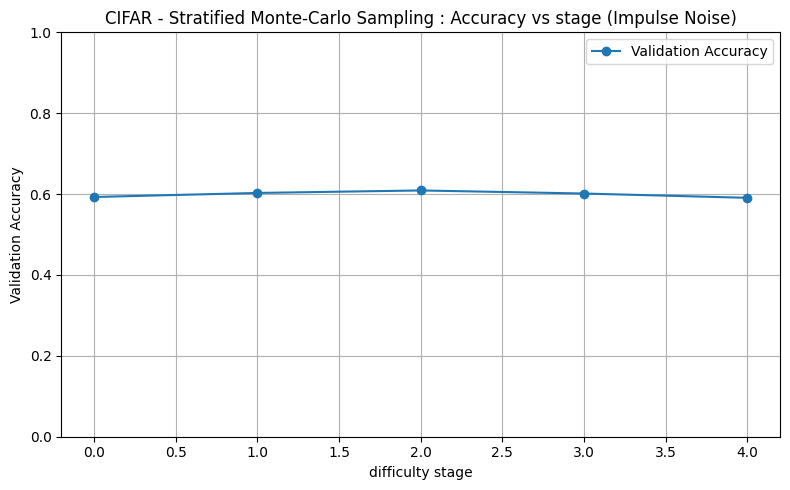

In [52]:
plot_validation_accuracy(
    range(num_stages),
    stage_accs,
    x_label="difficulty stage",
    title="CIFAR - Stratified Monte-Carlo Sampling : Accuracy vs stage (Impulse Noise)",
    convergence_epoch=convergence_idx)